1. Import library
2. Dataset import and description
3. Data Cleaning
4. EDA

Library import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

Dataset import and description

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
train_transaction = pd.read_csv("/content/gdrive/MyDrive/DS_Datas/IEEE CIS Card Fraud detection/train_transaction.csv")

In [5]:
train_transaction.shape

(590540, 394)

As the data size is too high and we need to lot of work on this data, hence we need to reduce the amount of memory it is holding

In [6]:
#memory reduction

def reduce_mem_usage2(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
train_transaction = reduce_mem_usage2(train_transaction)

Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 487.16 MB
Decreased by 72.6%


72.6% memory consumption has been reduced

In [8]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
columns = train_transaction.columns

In [10]:
train_transaction.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.0,588975.0,586281.0,524834.0,524834.0,238269.0,37627.0,590540.0,590540.0,590540.000000,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,589271.0,309743.0,327662.0,421618.0,280699.0,73187.0,38917.0,74926.000000,74926.000000,514518.0,311253.0,64717.0,61952.0,62187.0,...,589271.000000,589271.000000,590528.0,590528.0,590528.0,590528.0,590528.000000,590528.000000,590528.000000,590528.0,590528.0000,590528.0,590528.0,589271.0,589271.0,589271.0,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,82351.0,82351.0,82351.0,82351.000000,82351.0,82351.000000,82351.000000,82351.0,82351.000000,82351.000000,82351.000000,82351.000000,82351.0,82351.0,82351.0,82351.000000,82351.000000,82351.000000
mean,3.282270e+06,0.034990,7.372311e+06,NaN,9898.734658,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN,0.005650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,0.560059,NaN,NaN,inf,inf,inf,...,0.045471,0.052002,NaN,NaN,NaN,NaN,139.743408,408.579376,230.389160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.817917,247.600327,162.151230,18.372953,42.073849,28.327173,NaN,NaN,NaN,0.058624,NaN,0.296387,0.336914,NaN,0.775391,721.741455,1375.778564,1014.619934,NaN,NaN,NaN,55.352417,151.160538,100.700874
std,1.704744e+05,0.183755,4.617224e+06,NaN,4901.170153,NaN,0.0,0.0,NaN,0.0,NaN,inf,NaN,NaN,0.150635,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,0.316650,NaN,NaN,inf,inf,inf,...,0.289795,0.318115,0.0,0.0,0.0,0.0,2348.553223,4391.532715,3021.302979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2269.960449,3979.808105,2792.950928,331.837372,473.217529,381.328247,NaN,NaN,NaN,0.304443,0.0,0.000000,0.000000,0.0,0.000000,6217.229980,11169.515625,7955.782227,NaN,NaN,NaN,668.375854,1095.057739,814.953247
min,2.987000e+06,0.000000,8.640000e+04,0.250977,1000.000000,100.0,100.0,100.0,100.0,10.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-122.0,0.0,-83.0,0.0,0.000000,0.000000,0.0,-53.0,-83.0,0.0,-193.0,...,0.000000,0.000000,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.312500,6019.000000,214.0,150.0,166.0,204.0,87.0,3.0,7.0,1.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,26.0,1.0,0.0,1.0,0.0,0.0,0.958496,0.208374,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.750000,9678.000000,361.0,150.0,226.0,299.0,87.0,8.0,37.0,1.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0,3.0,97.0,8.0,26.0,10.0,0.0,0.0,37.875000,0.666504,15.0,43.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.0,150.0,226.0,330.0,87.0,24.0,206.0,3.0,3.0,0.000000,0.0,1.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,12.0,2.0,122.0,276.0,27.0,253.0,32.0,40.0,17.0,188.000000,0.833496,1

Outliers:

TransactionAmt, 
V127 - V140, 
V150 - V151, 
V159 - V336

In [11]:
train_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: category(14), float16(332), float32(44), int16(1), int32(2), int8(1)
memory usage: 487.2 MB


train_transaction.info() is too high to display

Data cleaning

In [12]:
#calculating Null value percentages and putting it in DataFrame df_null

null_columns = train_transaction.columns[train_transaction.isnull().any()]
null_values = 100*train_transaction[null_columns].isnull().sum()/train_transaction.shape[0]
df_null=pd.DataFrame(null_values)
df_null.index.name ='Feature'
df_null.rename(columns={0:'Percent'},inplace=True)
df_null.reset_index(drop=False, inplace=True)
df_null = df_null.sort_values(['Percent'],ascending=False).reset_index(drop=True)
print(df_null)

    Feature    Percent
0     dist2  93.628374
1        D7  93.409930
2       D13  89.509263
3       D14  89.469469
4       D12  89.041047
..      ...        ...
369    V307   0.002032
370    V308   0.002032
371    V309   0.002032
372    V279   0.002032
373    V294   0.002032

[374 rows x 2 columns]


In [13]:
# number of columns above 25% Null

df_null[df_null['Percent']>25.0]

,Feature,Percent
0,dist2,93.628374
1,D7,93.409930
2,D13,89.509263
3,D14,89.469469
4,D12,89.041047
...,...,...
207,V50,28.612626
208,V49,28.612626
209,V48,28.612626
210,V35,28.612626


In [14]:
#dropping the coulmns above 25% Null values
train_transaction.drop(df_null[df_null['Percent']>25.0].Feature, axis=1, inplace=True)

In [15]:
train_transaction.shape

(590540, 182)

In [16]:
#checking columns who has null values above 25% and more than 10% and putting them into a new Data Frame
df_null_10_25 = df_null[(df_null['Percent']<25) & (df_null['Percent']>10)]
df_null_10_25.reset_index(drop=True, inplace=True)
df_null_10_25

,Feature,Percent
0,P_emaildomain,15.994852
1,V81,15.098723
2,V77,15.098723
3,V82,15.098723
4,V83,15.098723
...,...,...
65,V13,12.881939
66,V12,12.881939
67,D10,12.873302
68,addr1,11.126427


In [17]:
#describing the columns with Nul values inbetween 25% to 10%

train_transaction[df_null_10_25.Feature].describe()

,V81,V77,V82,V83,V84,V85,V86,V87,V79,V78,V76,V92,V75,V88,V89,V90,V91,V94,V93,V80,D15,V70,V53,V64,V74,V72,V71,V69,V68,V67,V66,V65,V63,V54,V62,V61,V60,V59,V58,V57,V56,V55,V73,V21,V22,V34,V32,V31,V30,V29,V28,V27,V26,V25,V24,V23,V33,V20,V19,V18,V17,V16,V15,V14,V13,V12,D10,addr1,addr2
count,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.000000,501376.0,501376.0,501376.0,501376.0,501376.0,501427.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.000000,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.000000,514467.000000,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.000000,514467.000000,514467.0,514467.0,514467.0,514518.0,524834.0,524834.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000830,0.000775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.123352,0.122375,NaN,NaN,NaN,NaN,NaN,NaN
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031952,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031128,0.028595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.342529,0.332520,0.0,0.0,0.0,NaN,NaN,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-83.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,100.0,10.0
25%,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,204.0,87.0
50%,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,52.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.000000,1.0,1.0,1.0,15.0,299.0,87.0
75%,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.000000,1.0,1.0,0.0,0.0,0.0,314.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.000000,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.000000,1.0,1.0,1.0,197.0,330.0,87.0
max,19.0,30.0,7.0,7.0,7.0,7.0,30.0,30.0,7.0,31.0,6.0,7.0,4.0,1.0,2.000000,5.0,6.0,2.0,7.0,19.0,879.0,6.0,5.0,7.0,8.0,10.0,6.0,5.0,2.000000,8.0,7.0,1.0,7.0,6.0,10.0,6.0,16.0,16.0,10.0,6.0,51.0,17.0,7.0,5.0,8.0,13.0,15.0,7.0,9.0,5.0,4.000000,4.000000,13.0,7.0,13.0,13.0,7.0,15.0,7.0,15.0,15.0,15.000000,7.000000,1.0,6.0,3.0,876.0,540.0,102.0


In [18]:
#checking on the data tyes of all the columns with Null values in between 10% to 25%
train_transaction[df_null_10_25.Feature].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 70 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   P_emaildomain  496084 non-null  category
 1   V81            501376 non-null  float16 
 2   V77            501376 non-null  float16 
 3   V82            501376 non-null  float16 
 4   V83            501376 non-null  float16 
 5   V84            501376 non-null  float16 
 6   V85            501376 non-null  float16 
 7   V86            501376 non-null  float16 
 8   V87            501376 non-null  float16 
 9   V79            501376 non-null  float16 
 10  V78            501376 non-null  float16 
 11  V76            501376 non-null  float16 
 12  V92            501376 non-null  float16 
 13  V75            501376 non-null  float16 
 14  V88            501376 non-null  float16 
 15  V89            501376 non-null  float16 
 16  V90            501376 non-null  float16 
 17  V91       

In [19]:
#Lets first check on how much percent of Data is termed as fraud
train_transaction['isFraud'].value_counts(normalize=True)

0    0.96501
1    0.03499
Name: isFraud, dtype: float64

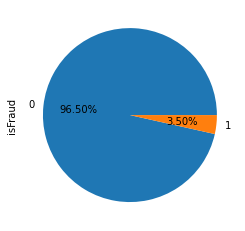

In [20]:
#ploting on fraud and non-fraud into graph
train_transaction['isFraud'].value_counts().plot.pie(autopct = '%1.2f%%');

Since the data is highly imbalanced so it will be better to divide the data frame in to two frames 0's and 1's correspondingly and then impute or delete null values

In [21]:
#Dividing into two dataframes
df_1 = train_transaction[train_transaction['isFraud']==1]
df_0 = train_transaction[train_transaction['isFraud']==0]
df_1.reset_index(drop=True,inplace=True)
df_0.reset_index(drop=True,inplace=True)

In [22]:
# Imputing values in P_emaildomain
df_1['P_emaildomain'].value_counts()

gmail.com           9943
hotmail.com         2396
yahoo.com           2297
anonymous.com        859
aol.com              617
outlook.com          482
comcast.net          246
icloud.com           197
mail.com             106
msn.com               90
live.com              84
outlook.es            57
bellsouth.net         53
ymail.com             50
live.com.mx           41
aim.com               40
protonmail.com        31
att.net               30
cox.net               29
me.com                27
charter.net           25
verizon.net           22
hotmail.es            20
optonline.net         17
yahoo.com.mx          16
mac.com               14
sbcglobal.net         12
gmail                 11
earthlink.net         11
embarqmail.com         9
frontier.com           8
juno.com               6
yahoo.fr               5
frontiernet.net        5
suddenlink.net         4
roadrunner.com         3
cableone.net           3
rocketmail.com         2
yahoo.es               2
sc.rr.com              1


In [23]:
#filling NA with anonymous.com
df_1['P_emaildomain'].fillna('anonymous.com', inplace=True)

In [24]:
#since the data for isFraud=0 is very high so it wont matter much if we delete rows containg Null values in P_emaildomain 
df_0['P_emaildomain'].fillna('anonymous.com', inplace=True)

In [25]:
#removing P_emaildomain from Null list
df_null_10_25 = df_null_10_25.iloc[1:,:]
df_null_10_25.reset_index(drop=True)

,Feature,Percent
0,V81,15.098723
1,V77,15.098723
2,V82,15.098723
3,V83,15.098723
4,V84,15.098723
...,...,...
64,V13,12.881939
65,V12,12.881939
66,D10,12.873302
67,addr1,11.126427


In [26]:
#checking data types of remaing columns which has Null Values in between 10% and 25%
train_transaction[df_null_10_25.Feature].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 69 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V81     501376 non-null  float16
 1   V77     501376 non-null  float16
 2   V82     501376 non-null  float16
 3   V83     501376 non-null  float16
 4   V84     501376 non-null  float16
 5   V85     501376 non-null  float16
 6   V86     501376 non-null  float16
 7   V87     501376 non-null  float16
 8   V79     501376 non-null  float16
 9   V78     501376 non-null  float16
 10  V76     501376 non-null  float16
 11  V92     501376 non-null  float16
 12  V75     501376 non-null  float16
 13  V88     501376 non-null  float16
 14  V89     501376 non-null  float16
 15  V90     501376 non-null  float16
 16  V91     501376 non-null  float16
 17  V94     501376 non-null  float16
 18  V93     501376 non-null  float16
 19  V80     501376 non-null  float16
 20  D15     501427 non-null  float16
 21  V70     51

Since all the data types are float so we can impute the null values of the columns to most frequent

In [27]:
null_columns = df_null_10_25.Feature

In [28]:
# using imuter to impute remaining columns which have null values in between 10%-25%
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy = 'most_frequent')
imp = imp.fit(df_0.loc[:,null_columns])
df_0.loc[:,null_columns] = imp.transform(df_0.loc[:,null_columns])

In [29]:
imp = SimpleImputer(missing_values=np.nan, strategy = 'most_frequent')
imp = imp.fit(df_0.loc[:,null_columns])
df_1.loc[:,null_columns] = imp.transform(df_1.loc[:,null_columns])

In [30]:
#re-calculating Null values for isFraud==0
null_columns = df_0.columns[df_0.isnull().any()]
null_values = 100*df_0[null_columns].isnull().sum()/df_0.shape[0]
df_null=pd.DataFrame(null_values)
df_null.index.name ='Feature'
df_null.rename(columns={0:'Percent'},inplace=True)
df_null.reset_index(drop=False, inplace=True)
df_null_0 = df_null.sort_values(['Percent'],ascending=False).reset_index(drop=True)
print(df_null_0)

   Feature   Percent
0    card2  1.493305
1    card5  0.710504
2    card4  0.269532
3    card6  0.268830
4    card3  0.267777
..     ...       ...
87    V295  0.001755
88    V297  0.001755
89    V298  0.001755
90    V299  0.001755
91    V321  0.001755

[92 rows x 2 columns]


We can delete rows of Dataframe df_0 which has null values less than 3% but for df_1 we need to impute as there is high imbalance

In [31]:
#dropping rows containg null values from df_0

df_0.dropna(inplace=True)

In [32]:
df_0.shape

(558065, 182)

In [33]:
#re-calculating Null values for isFraud==1
null_columns_1 = df_1.columns[df_1.isnull().any()]
null_values = 100*df_1[null_columns_1].isnull().sum()/df_1.shape[0]
df_null=pd.DataFrame(null_values)
df_null.index.name ='Feature'
df_null.rename(columns={0:'Percent'},inplace=True)
df_null.reset_index(drop=False, inplace=True)
df_null_1 = df_null.sort_values(['Percent'],ascending=False).reset_index(drop=True)
print(df_null_1)

   Feature   Percent
0    card2  2.047137
1    card5  1.016309
2     V301  0.222620
3     V282  0.222620
4     V283  0.222620
..     ...       ...
87    V295  0.009679
88    V297  0.009679
89    V298  0.009679
90    V299  0.009679
91    V321  0.009679

[92 rows x 2 columns]


In [34]:
#Lets check on data tpyes of the Null values
df_1[null_columns_1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20663 entries, 0 to 20662
Data columns (total 92 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   card2   20240 non-null  float16 
 1   card3   20624 non-null  float16 
 2   card4   20622 non-null  category
 3   card5   20453 non-null  float16 
 4   card6   20624 non-null  category
 5   D1      20617 non-null  float16 
 6   V95     20646 non-null  float16 
 7   V96     20646 non-null  float16 
 8   V97     20646 non-null  float16 
 9   V98     20646 non-null  float16 
 10  V99     20646 non-null  float16 
 11  V100    20646 non-null  float16 
 12  V101    20646 non-null  float16 
 13  V102    20646 non-null  float16 
 14  V103    20646 non-null  float16 
 15  V104    20646 non-null  float16 
 16  V105    20646 non-null  float16 
 17  V106    20646 non-null  float16 
 18  V107    20646 non-null  float16 
 19  V108    20646 non-null  float16 
 20  V109    20646 non-null  float16 
 21  V110    2064

In [35]:
#lets check the card variables first

df_1['card2'].value_counts()

545.0    1420
321.0    1396
111.0     978
555.0     959
490.0     916
         ... 
504.0       1
591.0       1
436.0       1
431.0       1
349.0       1
Name: card2, Length: 327, dtype: int64

In [36]:
df_1['card3'].value_counts()

150.0    12807
185.0     7362
144.0      112
119.0       70
143.0       28
         ...  
126.0        1
195.0        1
183.0        1
167.0        1
208.0        1
Name: card3, Length: 62, dtype: int64

In [37]:
df_1['card4'].value_counts()

visa                13373
mastercard           6496
discover              514
american express      239
Name: card4, dtype: int64

In [38]:
df_1['card5'].value_counts()

226.0    8753
224.0    3152
102.0    1832
137.0    1725
138.0    1682
195.0     681
166.0     630
219.0     571
117.0     354
162.0     301
126.0     105
197.0      86
223.0      83
202.0      58
147.0      47
198.0      34
229.0      32
141.0      32
203.0      28
150.0      23
146.0      23
190.0      20
236.0      20
185.0      19
100.0      18
144.0      16
118.0      15
228.0      13
194.0      13
142.0      12
129.0       9
135.0       8
133.0       8
132.0       7
119.0       6
149.0       5
212.0       5
107.0       4
232.0       4
143.0       4
139.0       3
183.0       3
159.0       2
237.0       2
134.0       1
199.0       1
167.0       1
191.0       1
131.0       1
Name: card5, dtype: int64

In [39]:
df_1['card6'].value_counts()

debit              10674
credit              9950
debit or credit        0
charge card            0
Name: card6, dtype: int64

In [40]:
# filling NA values of card2,3 and 5 with -999

df_1['card2'].fillna(-999.0,inplace=True)
df_1['card3'].fillna(-999.0,inplace=True)
df_1['card5'].fillna(-999.0,inplace=True)

In [41]:
#filling card4 and card6 with No Card and Unknown repectively
df_1['card6'] = df_1['card6'].cat.add_categories('No Card')
df_1['card6'].fillna('No Card', inplace=True)
df_1['card4'] = df_1['card4'].cat.add_categories('Unknown')
df_1['card4'].fillna('Unknown', inplace=True)

In [42]:
#re-calculating null values
null_columns_1 = df_1.columns[df_1.isnull().any()]
null_values = 100*df_1[null_columns_1].isnull().sum()/df_1.shape[0]
df_null=pd.DataFrame(null_values)
df_null.index.name ='Feature'
df_null.rename(columns={0:'Percent'},inplace=True)
df_null.reset_index(drop=False, inplace=True)
df_null_1 = df_null.sort_values(['Percent'],ascending=False).reset_index(drop=True)
print(df_null_1)

   Feature   Percent
0       D1  0.222620
1     V296  0.222620
2     V281  0.222620
3     V282  0.222620
4     V283  0.222620
..     ...       ...
82    V295  0.009679
83    V297  0.009679
84    V298  0.009679
85    V299  0.009679
86    V321  0.009679

[87 rows x 2 columns]


In [43]:
#checking datates of all the null columns
df_1[null_columns_1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20663 entries, 0 to 20662
Data columns (total 87 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   D1      20617 non-null  float16
 1   V95     20646 non-null  float16
 2   V96     20646 non-null  float16
 3   V97     20646 non-null  float16
 4   V98     20646 non-null  float16
 5   V99     20646 non-null  float16
 6   V100    20646 non-null  float16
 7   V101    20646 non-null  float16
 8   V102    20646 non-null  float16
 9   V103    20646 non-null  float16
 10  V104    20646 non-null  float16
 11  V105    20646 non-null  float16
 12  V106    20646 non-null  float16
 13  V107    20646 non-null  float16
 14  V108    20646 non-null  float16
 15  V109    20646 non-null  float16
 16  V110    20646 non-null  float16
 17  V111    20646 non-null  float16
 18  V112    20646 non-null  float16
 19  V113    20646 non-null  float16
 20  V114    20646 non-null  float16
 21  V115    20646 non-null  float16
 22

In [44]:
# replacing these null values with most frequesnt value of each column

im = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
im = im.fit(df_1.loc[:,null_columns_1])
df_1.loc[:,null_columns_1] = im.transform(df_1.loc[:,null_columns_1])

In [45]:
#checking for columns containg NULL values
df_1.columns[df_1.isnull().any()]

Index([], dtype='object')

In [46]:
df_0.columns[df_0.isnull().any()]

Index([], dtype='object')

In [47]:
df_0.shape

(558065, 182)

The size of dataframe df_0 is high. We will take 50% of data at random so that it becomes faster to compute also it will reduce imbalance to an extent

In [48]:
# working on 50% of isFraud==0 data
df_0 = df_0.sample(frac=0.5, random_state = 2)

In [49]:
df_0.shape

(279032, 182)

In [50]:
df_1.shape

(20663, 182)

In [51]:
#merging df_1 and df_0
df = pd.concat([df_1, df_0],axis=0)

In [52]:
#Checking for Null values
df.columns[df.isnull().any()]

Index([], dtype='object')

In [53]:
df.shape

(299695, 182)

In [54]:
#Enabling grabage collector to flush grabage if any
import gc
gc.enable()

In [55]:
#Deleting temprorary DataFrames that were created
del(df_1)
del(df_0)
del(df_null)
del(df_null_1)
del(df_null_0)
del(df_null_10_25)

In [56]:
start = 0
sets = 10
columns=df.columns
while ((start+sets) < len(columns)):
  end = start+sets
  print(df[columns[start:end]].info())
  start=end

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299695 entries, 0 to 446551
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   TransactionID   299695 non-null  int32   
 1   isFraud         299695 non-null  int8    
 2   TransactionDT   299695 non-null  int32   
 3   TransactionAmt  299695 non-null  float16 
 4   ProductCD       299695 non-null  category
 5   card1           299695 non-null  int16   
 6   card2           299695 non-null  float16 
 7   card3           299695 non-null  float16 
 8   card4           299695 non-null  object  
 9   card5           299695 non-null  float16 
dtypes: category(1), float16(4), int16(1), int32(2), int8(1), object(1)
memory usage: 10.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 299695 entries, 0 to 446551
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   card6          29

In [57]:
#Dropping Transaction ID as it is not required in Model creation
Transactions = df['TransactionID']
df.drop(['TransactionID'], axis=1,inplace=True)

In [58]:
#checking for columns with dtype category or object
df.columns[df.dtypes=='category']

Index(['ProductCD', 'P_emaildomain'], dtype='object')

In [59]:
df.columns[df.dtypes=='object']

Index(['card4', 'card6'], dtype='object')

In [60]:
#getting dummy values of all the object and category variables
ProcuctCD = pd.get_dummies(df['ProductCD'],prefix='ProdCD',drop_first=True)
Email = pd.get_dummies(df['P_emaildomain'],prefix='Email',drop_first=True)
card4 = pd.get_dummies(df['card4'],prefix='card4',drop_first=True)
card6 = pd.get_dummies(df['card6'],prefix='card6',drop_first=True)

In [61]:
#concating them to the dataframe
df = pd.concat([df,ProcuctCD,Email,card4,card6], axis=1)

In [62]:
#dropping categorical variables
df.drop(['ProductCD','P_emaildomain','card4','card6'], axis=1, inplace=True)

In [63]:
#transforming TransactionDT to DateTime object staring from 2017-12-01

import datetime
start_date = '2017-12-01'
start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
df['TransactionDT'] = df['TransactionDT'].apply(lambda x: start_date + datetime.timedelta(seconds=x))

In [64]:
df.head()

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,...,Email_live.fr,Email_mac.com,Email_mail.com,Email_me.com,Email_msn.com,Email_netzero.com,Email_netzero.net,Email_optonline.net,Email_outlook.com,Email_outlook.es,Email_prodigy.net.mx,Email_protonmail.com,Email_ptd.net,Email_q.com,Email_roadrunner.com,Email_rocketmail.com,Email_sbcglobal.net,Email_sc.rr.com,Email_servicios-ta.com,Email_suddenlink.net,Email_twc.com,Email_verizon.net,Email_web.de,Email_windstream.net,Email_yahoo.co.jp,Email_yahoo.co.uk,Email_yahoo.com,Email_yahoo.com.mx,Email_yahoo.de,Email_yahoo.es,Email_yahoo.fr,Email_ymail.com,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit
0,1,2017-12-02 00:56:00,445.00000,18268,583.0,150.0,226.0,251.0,87.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,4.0,2.0,57.0,80.0,374.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,1,2017-12-02 01:03:13,37.09375,13413,103.0,185.0,137.0,299.0,87.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,1,2017-12-02 01:04:06,37.09375,13413,103.0,185.0,137.0,299.0,87.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,1,2017-12-02 01:04:55,37.09375,13413,103.0,185.0,137.0,299.0,87.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,1,2017-12-02 01:16:26,155.50000,16578,545.0,185.0,226.0,299.0,87.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [65]:
#transforming TransactionDT to Date and Time
df['TransactionDT'] = df['TransactionDT'].astype('str')
df = pd.concat([df,df['TransactionDT'].str.split(expand=True)], axis=1)

In [66]:
df.rename(columns={0:'Date',1:'Time'}, inplace=True)

In [67]:
#dropping TransactionDT as it is no more required
df.drop(['TransactionDT'], axis=1,inplace=True)

In [68]:
#from the dates available we can filter out dates in which there were holidays in US
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

Dates = df['Date']
c = calendar()
holidays = c.holidays(start=Dates.min(), end=Dates.max())
holidays

DatetimeIndex(['2017-12-25', '2018-01-01', '2018-01-15', '2018-02-19',
               '2018-05-28'],
              dtype='datetime64[ns]', freq=None)

In [69]:
#creating isHoliday or not column
df['isHoliday'] = df['Date'].apply(lambda x: 1 if x in holidays else 0)

In [70]:
#from the dates we can also impute if it was weekday/weekend

df['weekday'] = df['Date'].apply(lambda x: len(pd.bdate_range(x,x)))

In [71]:
#converting the Time coulmn into standard time format
df['Time_Hour'] = pd.to_datetime(df['Time'],format='%H:%M:%S').dt.hour

In [72]:
df['Time_Hour'].value_counts()

19    21477
18    21274
21    21075
20    20976
22    20892
17    20638
23    20129
16    19527
0     19132
15    16958
1     16655
14    14111
2     13608
3     10762
13    10149
4      7629
12     6233
5      5137
11     3520
6      3160
7      2040
10     1926
8      1359
9      1328
Name: Time_Hour, dtype: int64

In [73]:
#bining time into 4 slots of Morning, Afternoon, Evening and Night
def hour_trans(h):
  if ((h>=6) and (h<12)):
    return 'Morning'
  elif ((h>=12) and (h<16)):
    return 'Afternoon'
  elif ((h>=16) and (h<20)):
    return 'Evening'
  else:
    return 'Night'

df['Day_Time'] = df['Time_Hour'].apply(hour_trans)


In [74]:
#Creating dummies out of Day_time columns and concatinating it to dataframe
dummies = pd.get_dummies(df['Day_Time'], drop_first=True, prefix_sep='_')
df = pd.concat([df,dummies], axis=1)
#df.drop(['Day_Time'], axis=1, inplace=True)

In [75]:
df.head()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,...,Email_outlook.es,Email_prodigy.net.mx,Email_protonmail.com,Email_ptd.net,Email_q.com,Email_roadrunner.com,Email_rocketmail.com,Email_sbcglobal.net,Email_sc.rr.com,Email_servicios-ta.com,Email_suddenlink.net,Email_twc.com,Email_verizon.net,Email_web.de,Email_windstream.net,Email_yahoo.co.jp,Email_yahoo.co.uk,Email_yahoo.com,Email_yahoo.com.mx,Email_yahoo.de,Email_yahoo.es,Email_yahoo.fr,Email_ymail.com,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit,Date,Time,isHoliday,weekday,Time_Hour,Day_Time,Evening,Morning,Night
0,1,445.00000,18268,583.0,150.0,226.0,251.0,87.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,4.0,2.0,57.0,80.0,374.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2017-12-02,00:56:00,0,0,0,Night,0,0,1
1,1,37.09375,13413,103.0,185.0,137.0,299.0,87.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2017-12-02,01:03:13,0,0,1,Night,0,0,1
2,1,37.09375,13413,103.0,185.0,137.0,299.0,87.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2017-12-02,01:04:06,0,0,1,Night,0,0,1
3,1,37.09375,13413,103.0,185.0,137.0,299.0,87.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2017-12-02,01:04:55,0,0,1,Night,0,0,1
4,1,155.50000,16578,545.0,185.0,226.0,299.0,87.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2017-12-02,01:16:26,0,0,1,Night,0,0,1


Outlier treatment

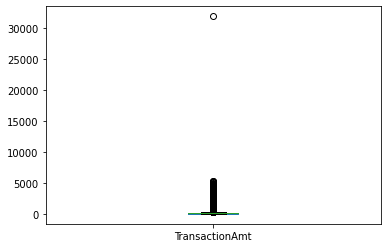

In [76]:
#Checking outliers in TansactionAmt column
df['TransactionAmt'].plot.box()

In [77]:
#checking if there are any frauds that happened with Transactions above 10000
df[df['TransactionAmt'] > 10000].isFraud.value_counts()

0    1
Name: isFraud, dtype: int64

In [78]:
#Since there are no frauds happened above 10000 we can cap the value at 10000
df = df[df['TransactionAmt'] <= 10000]

Exploratry Data Analysis

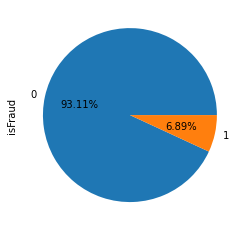

In [79]:
#checking for imbance in data
df.isFraud.value_counts(normalize=True).plot.pie(autopct='%1.2f%%')
plt.show()

Data is highly imbalanced, we need to create models looking into this imbalance

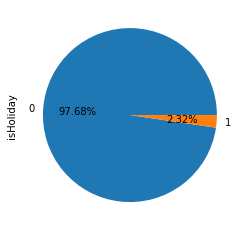

In [80]:
#Lets check if holiday has any effect on Fraud
df[df.isFraud==1].isHoliday.value_counts(normalize=True).plot.pie(autopct='%1.2f%%')
plt.show()

2.32% Fraud happened on Holidays and most of them happened during working days

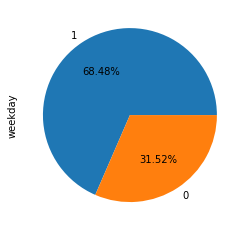

In [81]:
#checking effect of weekday/weekend on Fraud

df[df['isFraud']==1].weekday.value_counts(normalize=True).plot.pie(autopct='%1.2f%%')

31.52% Frauds happened during weekdays

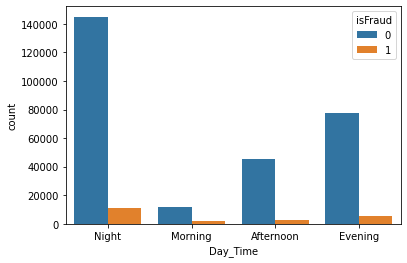

In [82]:
#lets check effect of durations in a day on Fraud

sns.countplot(x='Day_Time', hue='isFraud', data=df)

Most of the fraud happend at Night time and least in Morning time

In [83]:
#checking for categorical variable
df.columns[df.dtypes=='category']

Index([], dtype='object')

In [84]:
#dropping 'Time','Time_Hour','Date' , 'Day_Time' columns as it is not required
df.drop(['Time','Time_Hour','Date', 'Day_Time'], axis=1, inplace=True)

Spliting into Train and Test

In [85]:
from sklearn.model_selection import train_test_split

In [86]:
y = df['isFraud'].values
df.drop(['isFraud'], axis=1, inplace=True)

In [87]:
y.shape

(299694,)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)

##Model building

### Creating Metrics and scoring function

As this is an imbalanced dataset we will be focusing more on F1 Score metrics.

In [89]:
from sklearn import metrics
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

def model_metrics(y_true, y_pred):
    # Confusion matrix 
    confusion = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix:\n',confusion,'\n')

    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives

    # Let's check the overall accuracy.
    accuracy = accuracy_score(y_true, y_pred)
    print('Overall Accuracy: ', accuracy)

    #F-1 Score
    F1_score = f1_score(y_true, y_pred)
    print('F-1 Score: ', F1_score)

    # Let's see the sensitivity/Recall of our logistic regression model
    Sensitivity = TP / float(TP+FN)
    print('Sensitivity/Recall: ',Sensitivity)

    # Let us calculate specificity
    Specificity = TN / float(TN+FP)
    print('Specificity: ',Specificity)

    # Calculate false postive rate - predicting Conversion when customer does not have Converted
    False_positive = FP/ float(TN+FP)
    print('False Positive Rate: ',False_positive)

    # Precision 
    Precision = TP / float(TP+FP)
    print('Positive Predictive Value i.e. Precision', Precision)

    # Negative predictive value
    Negetive_predict = TN / float(TN+ FN)
    print('Negative predictive value',Negetive_predict)

    return F1_score, Sensitivity, False_positive, Precision, Negetive_predict, accuracy

### Creating Base model first (Logistic Regression)

In [90]:
#first dropping all highly correlated columns
corr_matrix = X_train.corr()
x = corr_matrix.index
y = corr_matrix.columns

high_corr = []
for ind in x:
  for col in y:
    if ind!=col:
      if abs(corr_matrix[ind][col]) > 0.7:
        high_corr.append(ind)
        high_corr.append(col)
high_corr = list(set(high_corr))

X_train_log = X_train.drop(high_corr, axis=1)
X_test_log = X_test.loc[:,X_train_log.columns]

In [91]:
#Scaling

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_log[['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'D1']] = scaler.fit_transform(X_train_log[['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'D1']])
X_test_log[['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'D1']] = scaler.fit_transform(X_test_log[['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'D1']])


In [92]:
#building model
#we are using class_weight=blanaced which will automatically compute imbalance in data and assign weights accordingly
from sklearn.linear_model import LogisticRegressionCV
base_model = LogisticRegressionCV(class_weight='balanced')

base_model.fit(X_train_log, y_train)



LogisticRegressionCV(Cs=10, class_weight='balanced', cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [93]:
#prediction on Test set
y_pred_base = base_model.predict(X_test_log)

In [94]:
#checking on metrics for this model
F1_score, Sensitivity, False_positive, Precision, Negetive_predict, Accuracy = model_metrics(y_test, y_pred_base)

Confusion Matrix:
 [[38577 17241]
 [ 1337  2784]] 

Overall Accuracy:  0.6900515524116185
F-1 Score:  0.2305972003644496
Sensitivity/Recall:  0.6755641834506187
Specificity:  0.6911211437170806
False Positive Rate:  0.3088788562829195
Positive Predictive Value i.e. Precision 0.13902621722846442
Negative predictive value 0.9665029814100315


In [127]:
scores = pd.DataFrame(columns=['Model','F1_score','Sensitivity', 'False_positive', 'Precision', 'Negetive_predict', 'Accuracy'])
scores = scores.append({'Model':'Logistic','F1_score':F1_score, 'Sensitivity':Sensitivity, 'False_positive':False_positive, 'Precision':Precision, 'Negetive_predict':Negetive_predict, 'Accuracy': Accuracy}, ignore_index=True)
scores

,Model,F1_score,Sensitivity,False_positive,Precision,Negetive_predict,Accuracy
0,Logistic,0.230597,0.675564,0.308879,0.139026,0.966503,0.690052


Since Data is highly imbalances so we can look at all the Fraud cases as an Anomaly and design algorithms accordingly. In these algorithms we dont need to scale data and remove highly correlated data.

Isolation Forest is one such algorithm that can be used here which looks into minority class of data as anomaly




### Isolation Forest

Isolation forest's algorithm is based on Random forest and Decision tree. Here we create a root node and randomly split the values. Here we assume that if one observation is similar to others, it will take more random splits as compared to an anomaly. Hence anomalies get isolated.

As we build multiple isolation trees, hence the isolation forest, for each observation we can calculate the average number of splits across all the trees that isolate the observation. The average number of splits is then used as a score, where the less splits the observation needs, the more likely it is to be anomalous.

The most important hyper-parameter in Isolation forest is contamination, it should be similar to percentage of anomaly/minority class in the dataset 

Isolation forest predicts anomalies/minority class as -1 and others as 1. Which we need to change to 1 and 0 correspondingly

In [96]:
from sklearn.ensemble import IsolationForest

In [97]:
model_2 = IsolationForest(contamination=0.07, behaviour='new')
trainX = X_train[y_train==0]
model_2.fit(trainX)

IsolationForest(behaviour='new', bootstrap=False, contamination=0.07,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [98]:
#prediction on test set
ypred_iso = model_2.predict(X_test)

In [99]:
#converting 1->0 and -1->1
ypred_iso[ypred_iso==1]=0
ypred_iso[ypred_iso==-1]=1

In [100]:
pd.DataFrame(ypred_iso).value_counts()

0    54644
1     5295
dtype: int64

In [101]:
F1_score_iso, Sensitivity_iso, False_positive_iso, Precision_iso, Negetive_predict_iso, Accuracy_iso = model_metrics(y_test, ypred_iso)

Confusion Matrix:
 [[51953  3865]
 [ 2691  1430]] 

Overall Accuracy:  0.8906221325013765
F-1 Score:  0.3037383177570094
Sensitivity/Recall:  0.3470031545741325
Specificity:  0.9307571034433337
False Positive Rate:  0.06924289655666631
Positive Predictive Value i.e. Precision 0.2700661000944287
Negative predictive value 0.9507539711587731


In [128]:
scores = scores.append({'Model':'Isolation Forest','F1_score':F1_score_iso, 'Sensitivity':Sensitivity_iso, 'False_positive':False_positive_iso, 'Precision':Precision_iso, 'Negetive_predict':Negetive_predict_iso, 'Accuracy': Accuracy_iso}, ignore_index=True)
scores

,Model,F1_score,Sensitivity,False_positive,Precision,Negetive_predict,Accuracy
0,Logistic,0.230597,0.675564,0.308879,0.139026,0.966503,0.690052
1,Isolation Forest,0.303738,0.347003,0.069243,0.270066,0.950754,0.890622


### Decision Tree

We will use Cross Validation technique to improve on f1_score
Here we are using StratifiedShuffleSplit to create 10 splits for X_train and F1_score as scoring

In [108]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=4)
class_weight = ['balanced']
criterion=['entropy']
params={'criterion': criterion, 'class_weight': class_weight}

model_3 = GridSearchCV(DecisionTreeClassifier(), param_grid=params, cv=cv, scoring='f1', n_jobs=-1)
model_3.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=4, test_size=0.25,
            train_size=None),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             i

In [109]:
ypred_3 = model_3.predict(X_test)

In [110]:
F1_score_3, Sensitivity_3, False_positive_3, Precision_3, Negetive_predict_3, Accuracy_3 = model_metrics(y_test, ypred_3)

Confusion Matrix:
 [[54238  1580]
 [ 1599  2522]] 

Overall Accuracy:  0.9469627454578822
F-1 Score:  0.6134014349993919
Sensitivity/Recall:  0.61198738170347
Specificity:  0.9716937188720485
False Positive Rate:  0.028306281127951558
Positive Predictive Value i.e. Precision 0.6148220380302292
Negative predictive value 0.9713630746637534


In [129]:
scores = scores.append({'Model':'Decision Tree','F1_score':F1_score_3, 'Sensitivity':Sensitivity_3, 'False_positive':False_positive_3, 'Precision':Precision_3, 'Negetive_predict':Negetive_predict_3, 'Accuracy': Accuracy_3}, ignore_index=True)
scores

,Model,F1_score,Sensitivity,False_positive,Precision,Negetive_predict,Accuracy
0,Logistic,0.230597,0.675564,0.308879,0.139026,0.966503,0.690052
1,Isolation Forest,0.303738,0.347003,0.069243,0.270066,0.950754,0.890622
2,Decision Tree,0.613401,0.611987,0.028306,0.614822,0.971363,0.946963


### Random Forest

In [122]:
from sklearn.ensemble import RandomForestClassifier

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=4)
class_weight = ['balanced']
criterion=['entropy']
params={'criterion': criterion, 'class_weight': class_weight}

model_4 = GridSearchCV(estimator=RandomForestClassifier(max_features='auto'), param_grid=params, cv=cv, scoring='f1')
model_4.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=4, test_size=0.25,
            train_size=None),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
      

In [124]:
ypred_4 = model_4.predict(X_test)

In [125]:
F1_score_4, Sensitivity_4, False_positive_4, Precision_4, Negetive_predict_4, Accuracy_4 = model_metrics(y_test, ypred_4)

Confusion Matrix:
 [[55638   180]
 [ 2039  2082]] 

Overall Accuracy:  0.9629790286791572
F-1 Score:  0.6523578254739151
Sensitivity/Recall:  0.5052171802960447
Specificity:  0.9967752337955498
False Positive Rate:  0.0032247662044501773
Positive Predictive Value i.e. Precision 0.9204244031830239
Negative predictive value 0.9646479532569309


In [130]:
scores = scores.append({'Model':'Random Forest','F1_score':F1_score_4, 'Sensitivity':Sensitivity_4, 'False_positive':False_positive_4, 'Precision':Precision_4, 'Negetive_predict':Negetive_predict_4, 'Accuracy': Accuracy_4}, ignore_index=True)
scores

,Model,F1_score,Sensitivity,False_positive,Precision,Negetive_predict,Accuracy
0,Logistic,0.230597,0.675564,0.308879,0.139026,0.966503,0.690052
1,Isolation Forest,0.303738,0.347003,0.069243,0.270066,0.950754,0.890622
2,Decision Tree,0.613401,0.611987,0.028306,0.614822,0.971363,0.946963
3,Random Forest,0.652358,0.505217,0.003225,0.920424,0.964648,0.962979


### XGBoost

In [131]:
from xgboost import XGBClassifier

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=4)
class_weight = ['balanced']
criterion=['entropy']
params={'criterion': criterion, 'class_weight': class_weight}

model_5 = GridSearchCV(estimator=XGBClassifier(), param_grid=params, cv=cv, scoring='f1')
model_5.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=4, test_size=0.25,
            train_size=None),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'class_weight': ['balanced'],
              

In [134]:
ypred_5= model_5.predict(X_test)

In [135]:
F1_score_5, Sensitivity_5, False_positive_5, Precision_5, Negetive_predict_5, Accuracy_5 = model_metrics(y_test, ypred_5)

Confusion Matrix:
 [[55659   159]
 [ 2694  1427]] 

Overall Accuracy:  0.9524016083017735
F-1 Score:  0.5000876117049238
Sensitivity/Recall:  0.34627517592817275
Specificity:  0.9971514565194023
False Positive Rate:  0.0028485434805976565
Positive Predictive Value i.e. Precision 0.8997477931904161
Negative predictive value 0.9538327078299316


In [138]:
scores = scores.append({'Model':'XGBoost','F1_score':F1_score_5, 'Sensitivity':Sensitivity_5, 'False_positive':False_positive_5, 'Precision':Precision_5, 'Negetive_predict':Negetive_predict_5, 'Accuracy': Accuracy_5}, ignore_index=True)
scores

,Model,F1_score,Sensitivity,False_positive,Precision,Negetive_predict,Accuracy
0,Logistic,0.230597,0.675564,0.308879,0.139026,0.966503,0.690052
1,Isolation Forest,0.303738,0.347003,0.069243,0.270066,0.950754,0.890622
2,Decision Tree,0.613401,0.611987,0.028306,0.614822,0.971363,0.946963
3,Random Forest,0.652358,0.505217,0.003225,0.920424,0.964648,0.962979
4,XGBoost,0.500088,0.346275,0.002849,0.899748,0.953833,0.952402


In [140]:
from sklearn.ensemble import ExtraTreesClassifier

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=4)
class_weight = ['balanced']
criterion=['entropy']
params={'criterion': criterion, 'class_weight': class_weight}

model_6 = GridSearchCV(estimator=ExtraTreesClassifier(), param_grid=params, cv=cv, scoring='f1')
model_6.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=4, test_size=0.25,
            train_size=None),
             error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None,
                                            oob_score=False, random_state

In [142]:
ypred_6=model_6.predict(X_test)

In [143]:
F1_score_6, Sensitivity_6, False_positive_6, Precision_6, Negetive_predict_6, Accuracy_6 = model_metrics(y_test, ypred_6)

Confusion Matrix:
 [[55539   279]
 [ 1919  2202]] 

Overall Accuracy:  0.9633293848746225
F-1 Score:  0.6670705846713118
Sensitivity/Recall:  0.5343363261344334
Specificity:  0.9950016123831023
False Positive Rate:  0.004998387616897775
Positive Predictive Value i.e. Precision 0.8875453446191052
Negative predictive value 0.9666016916704375


In [144]:
scores = scores.append({'Model':'Extra Trees','F1_score':F1_score_6, 'Sensitivity':Sensitivity_6, 'False_positive':False_positive_6, 'Precision':Precision_6, 'Negetive_predict':Negetive_predict_6, 'Accuracy': Accuracy_6}, ignore_index=True)
scores

,Model,F1_score,Sensitivity,False_positive,Precision,Negetive_predict,Accuracy
0,Logistic,0.230597,0.675564,0.308879,0.139026,0.966503,0.690052
1,Isolation Forest,0.303738,0.347003,0.069243,0.270066,0.950754,0.890622
2,Decision Tree,0.613401,0.611987,0.028306,0.614822,0.971363,0.946963
3,Random Forest,0.652358,0.505217,0.003225,0.920424,0.964648,0.962979
4,XGBoost,0.500088,0.346275,0.002849,0.899748,0.953833,0.952402
5,Extra Trees,0.667071,0.534336,0.004998,0.887545,0.966602,0.963329


The above table shows that the best Model for this dataset is Extra Trees. It is giving F1-score as 0.667 and accuracy as 0.96 with False_positive Rate: 0.0049